# Solution

В этом ноутбуке мы поэкспериментируем с данными, которые мы очистили, выберем признаки для предсказания и обучим несколько простеньких моделек.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

Посмотрим на данные:

In [2]:
df = pd.read_csv('processed/combined.csv').drop('mid', axis=1)

df.head()

,player_0_kills,player_0_deaths,player_0_assists,player_0_winrate,player_0_gold,player_1_kills,player_1_deaths,player_1_assists,player_1_winrate,player_1_gold,...,radiant_top_gold_4,radiant_sum_gold,dire_top_gold_0,dire_top_gold_1,dire_top_gold_2,dire_top_gold_3,dire_top_gold_4,dire_sum_gold,radiant_wr,dire_wr
0,9,3,18,0.453868,10960,13,3,18,0.494536,17760,...,23825,87245,5035,10355,12285,13395,17550,58620,0.035146,0.035846
1,3,4,9,0.503400,12160,9,10,8,0.473653,19625,...,19625,69310,19165,20275,21840,22305,24165,107750,0.027891,0.043353
2,5,13,7,0.494536,7990,6,11,5,0.516441,12515,...,13845,54990,10635,13990,15760,20500,20735,81620,0.031233,0.029213
3,4,13,21,0.528383,9690,24,13,22,0.468132,18550,...,19055,76685,13000,13280,20350,23505,24295,94430,0.028674,0.035620
4,8,2,10,0.515875,18605,18,4,9,0.447970,19675,...,19675,78980,5560,6915,7770,7770,10965,38980,0.032880,0.034994


Тут *очень* много признаков. Давайте соберём облегченную версию этой таблички. Но сначала посмотрим на корелляции в данных, которые у нас есть:

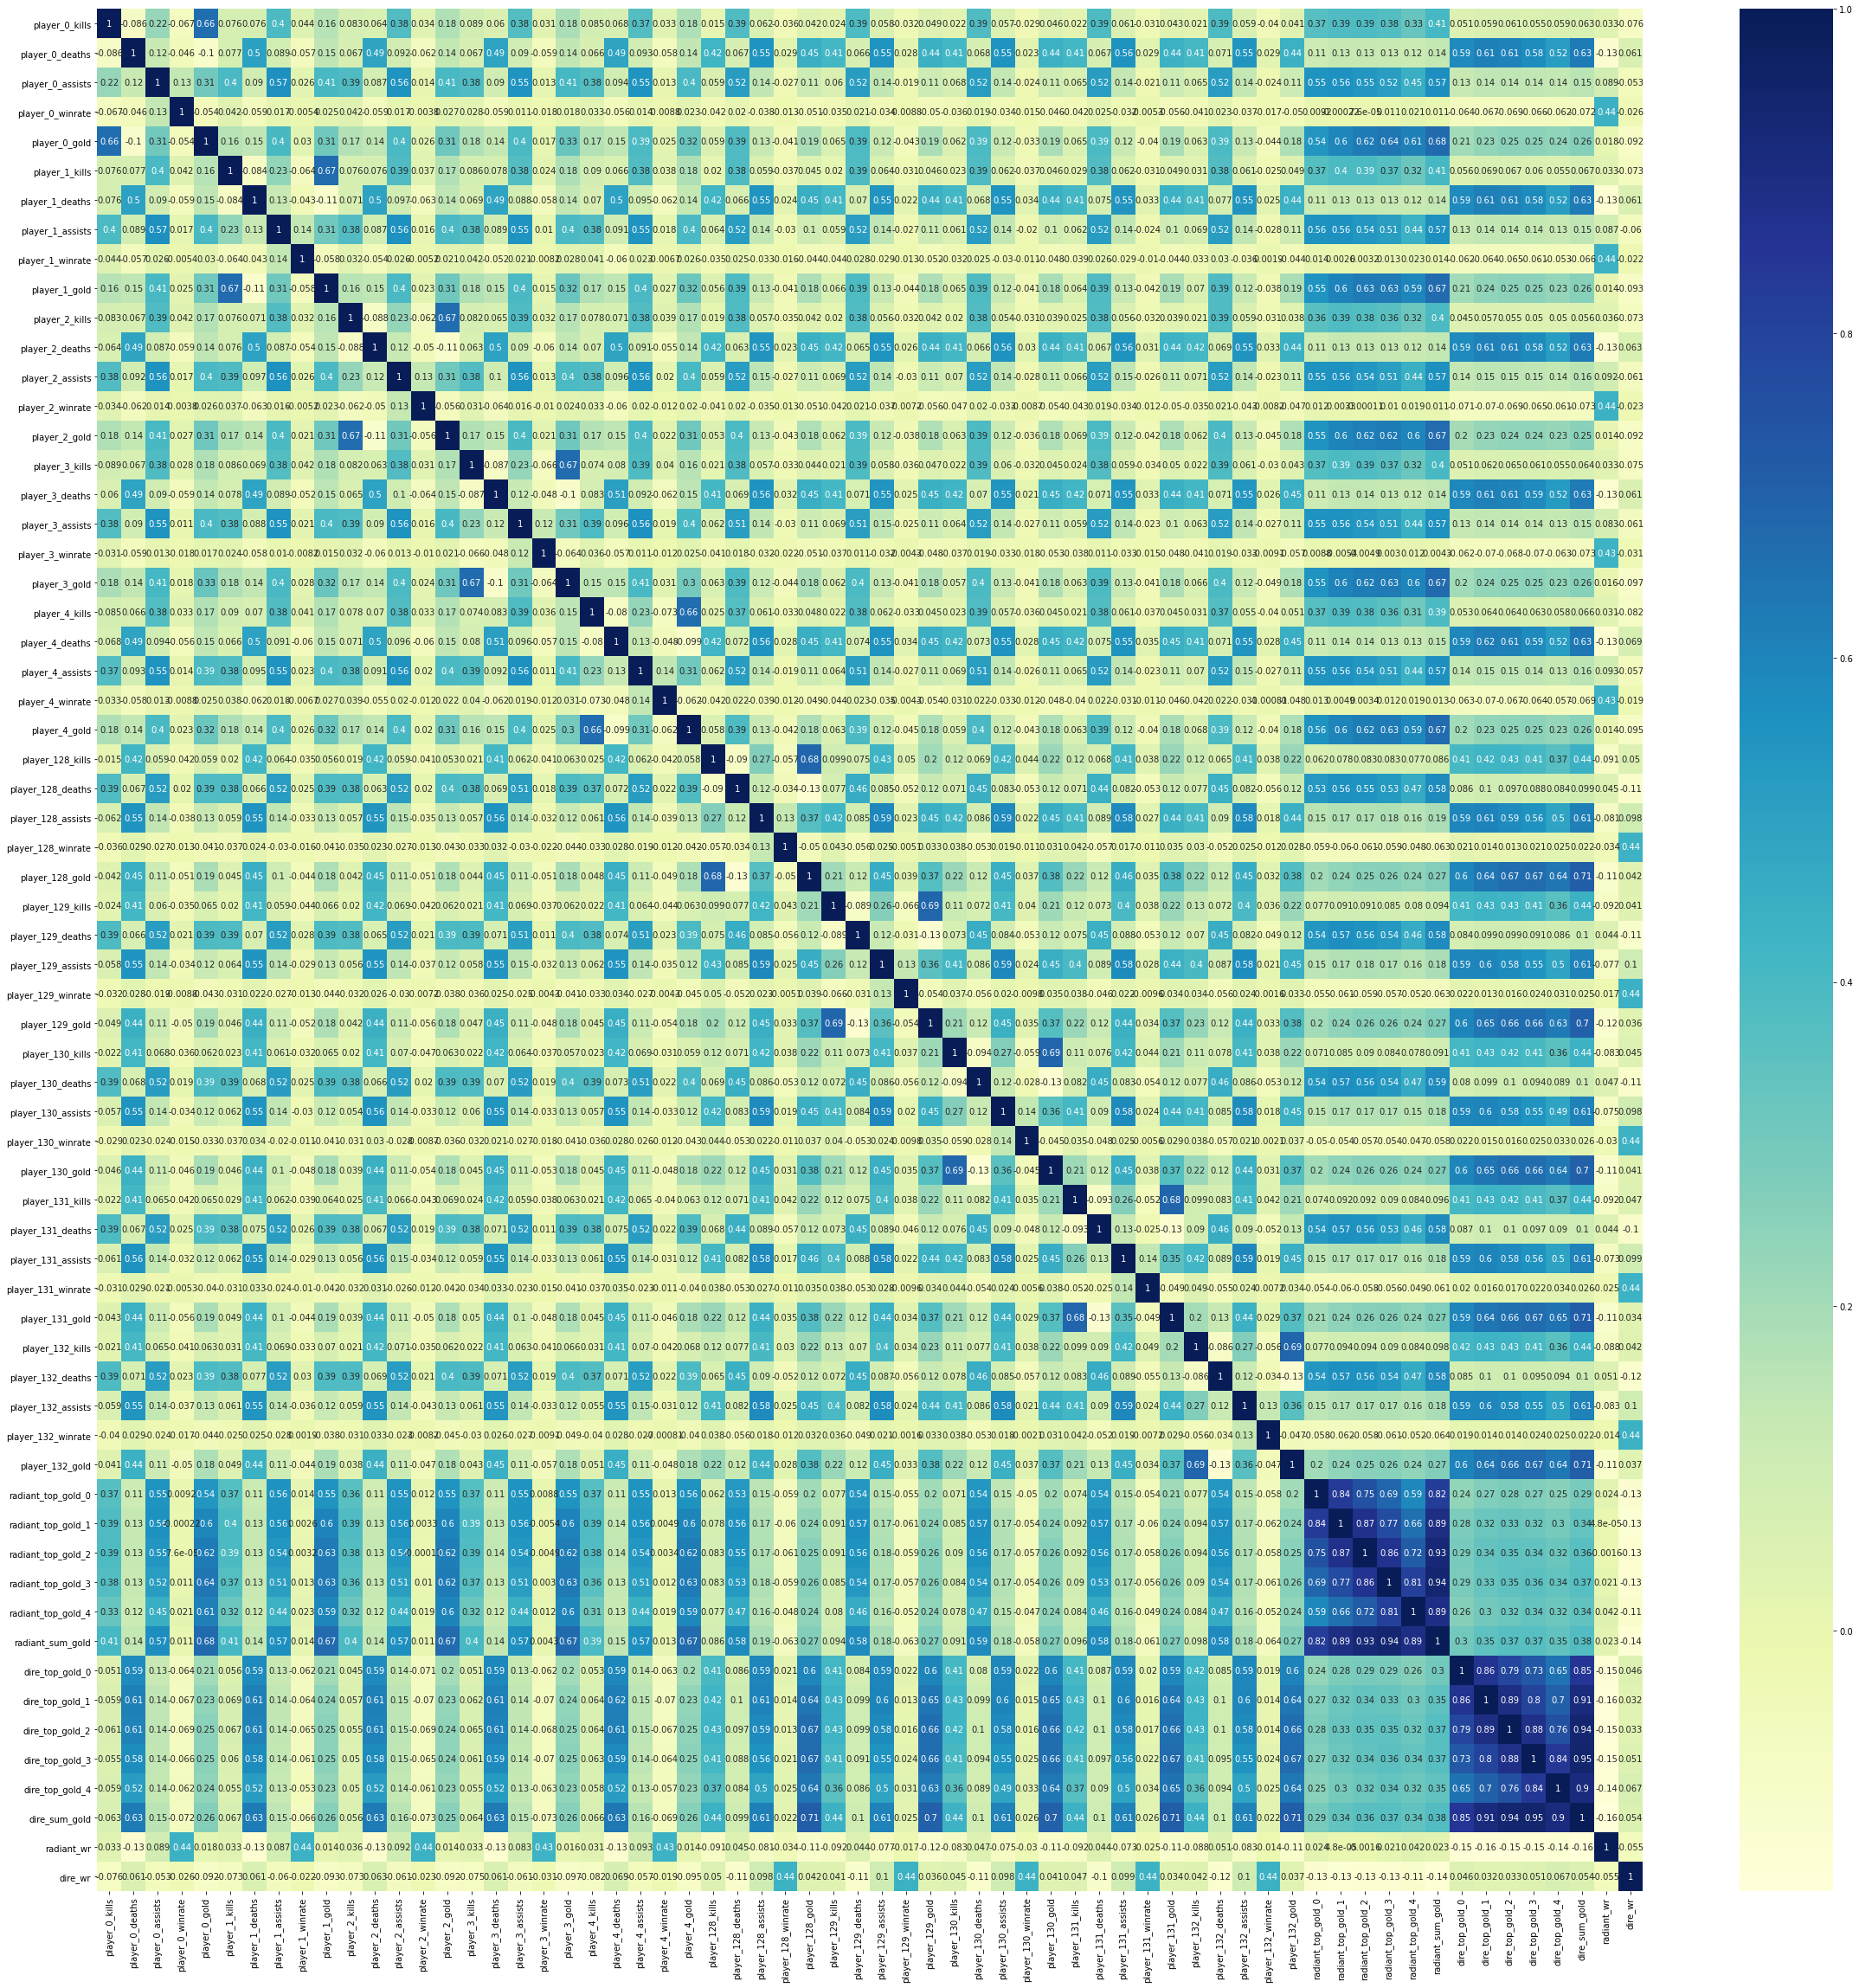

In [3]:
def draw_corr_matrix(df: pd.DataFrame):
    corr_matrix = df.corr()
    plt.figure(figsize=(40,40))
    sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
    
draw_corr_matrix(df)

Очень большая табличка, значения сложно разбирать, но давайте всё же выцепим отсюда несколько важных моментов - винрейты практически ни с чем не кореллируют (кроме своей комбинации), это классно, смерти и убийства одного игрока между собой кореллируют слабо, зато отсортированные по золоту игроки одной команды кореллируют просто жутко. Давайте на основе этого понимания вытащим из этой огромной таблички маленькое количество признаков, по которым и будем предсказывать победу команды.

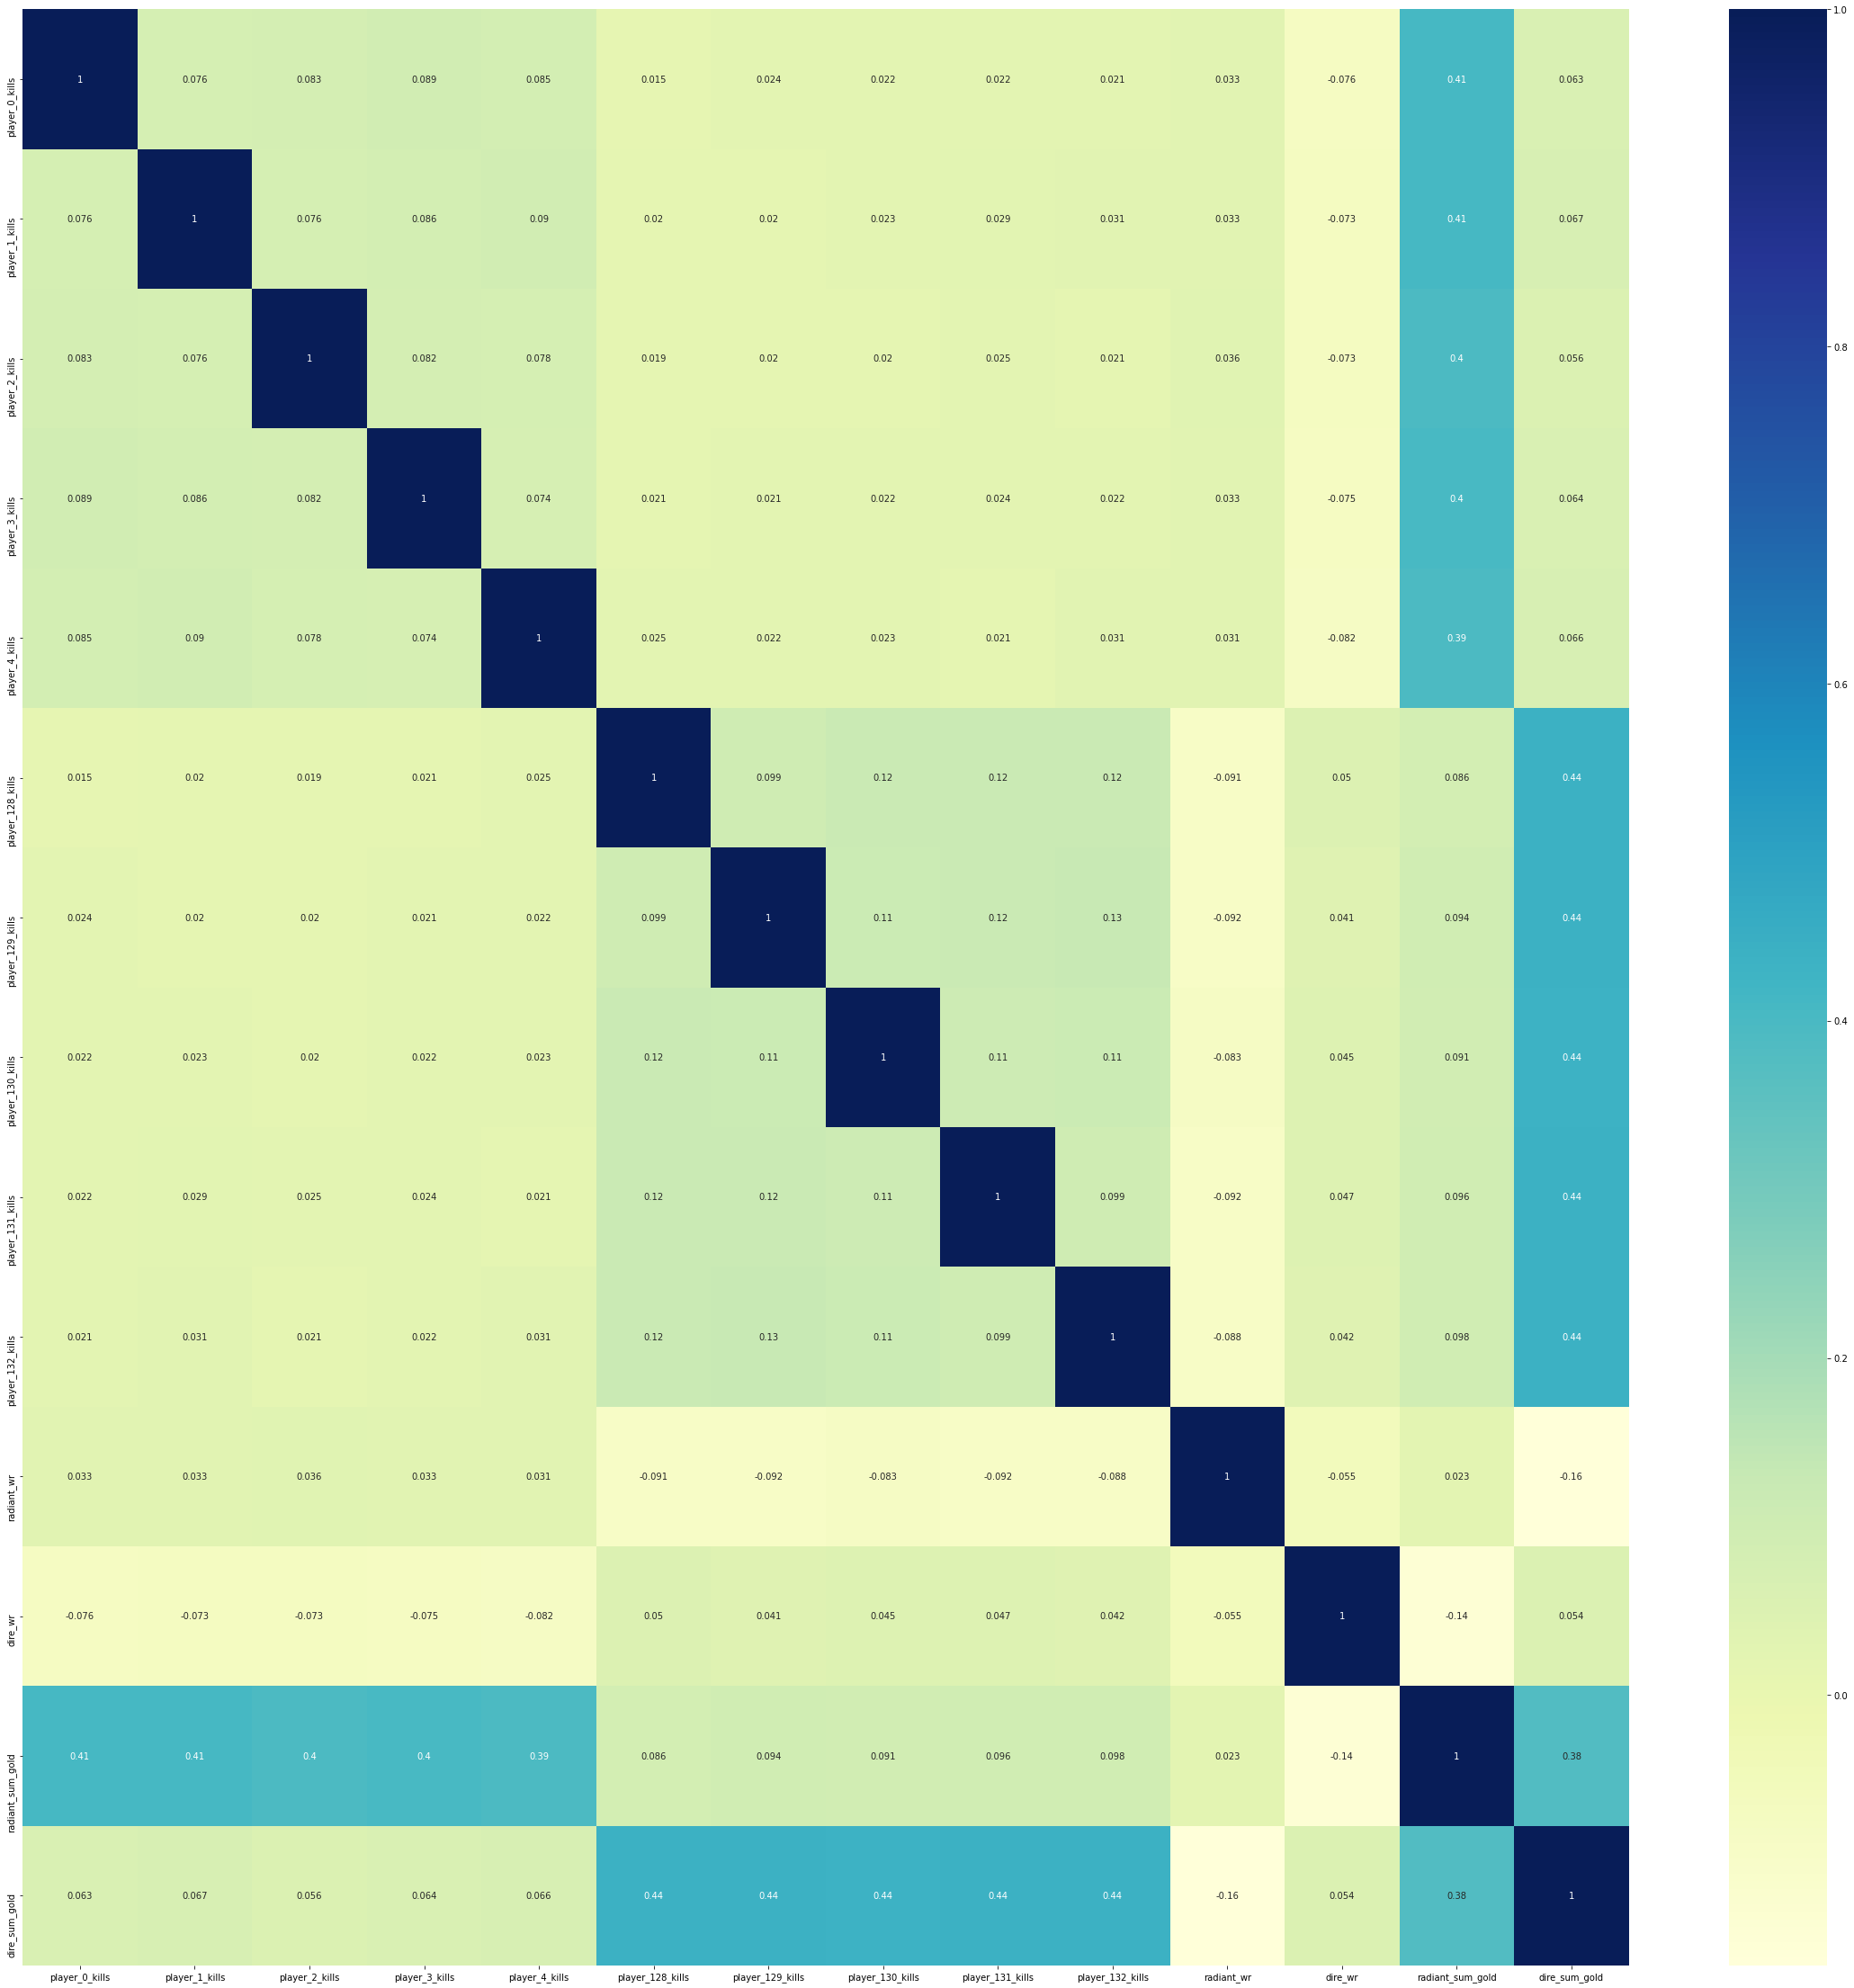

In [4]:
from typing import List

selected_features = [
    'player_0_kills', 'player_1_kills', 'player_2_kills', 'player_3_kills', 'player_4_kills', # radiant kills
    'player_128_kills', 'player_129_kills', 'player_130_kills', 'player_131_kills', 'player_132_kills', # dire kills
    'radiant_wr', 'dire_wr', # winrates
    'radiant_sum_gold', 'dire_sum_gold' # golds
]

def select_features(df: pd.DataFrame, features: List[str]):
    return df[features].copy()

light_df = select_features(df, selected_features)

draw_corr_matrix(light_df)

Кажется, мы отобрали довольно нормальные признаки (слабо кореллирующие между собой). Посмотрим на нормальность разных признаков:

In [5]:
from scipy.stats import normaltest

def pvalue_of_feature(feature: np.ndarray, size: int = 100) -> float:
    sample = np.random.choice(feature, size=size)
    _, pvalue = normaltest((sample - np.mean(sample)) / np.std(sample))
    return pvalue

for feature in selected_features:
    print(feature + ': ' + str(pvalue_of_feature(light_df[feature])))

player_0_kills: 0.010650653878507808
player_1_kills: 0.0006414707503924218
player_2_kills: 0.12391613991862607
player_3_kills: 7.367493577236094e-19
player_4_kills: 5.293060386915181e-08
player_128_kills: 7.346670754361216e-05
player_129_kills: 0.00012601430485954863
player_130_kills: 0.00117480019341239
player_131_kills: 1.199288295020209e-09
player_132_kills: 0.04837183690500037
radiant_wr: 0.17642974729637
dire_wr: 0.1841620072573786
radiant_sum_gold: 0.7327210159463164
dire_sum_gold: 0.674306204604108


Как можно видеть, винрейты и общее золото с очень большой точностью являются нормально распределёнными признакоми (это весьма осмысленно), остальные же признаки не значимы даже если взять точность `0.01`.

## Немного саппортящего кода для моделек

Поимпортим всё что нам нужно в жизни.

In [6]:
from sklearn.preprocessing import StandardScaler

from sklearn.base import ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

Теперь достанем лейблы и поделим на трейн и тест:

In [7]:
labels = pd.read_csv('processed/labels.csv')['radiant_win']

random_state = np.random.RandomState(seed=42)

X_train, X_test, y_train, y_test = train_test_split(light_df, labels, test_size=0.5, shuffle=True, random_state=random_state)

In [8]:
def print_scores(clf: ClassifierMixin, true: np.ndarray, data: np.ndarray, is_proba: bool = True):
    if is_proba: # If proba is available, then print ROC-AUC
        print("ROC-AUC score: {}".format(roc_auc_score(true, list(zip(*clf.predict_proba(data)))[1])))
        
    pred = clf.predict(data)   
    print("f1 score: {}".format(f1_score(true, pred)))
    
    cm_lr = confusion_matrix(true, pred)

    plt.figure(figsize = (5, 5))
    sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def make_model(clf: ClassifierMixin, random_state: np.random.RandomState, is_proba: bool = True):
    scaler = StandardScaler()
    
    _X_train = scaler.fit_transform(X_train)  
    _X_test = scaler.transform(X_test)
   
    clf.fit(_X_train, y_train)
    
    print("Train scores:")
    print_scores(clf, y_train, _X_train, is_proba)
    
    print("Testing scores:")
    print_scores(clf, y_test, _X_test, is_proba)
    
    return clf

## Поехали обучать модельки!

### Логистическая регрессия

Train scores:
ROC-AUC score: 0.990578284318531
f1 score: 0.9568144880427212


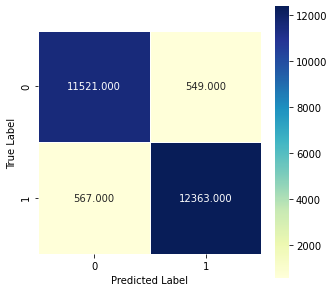

Testing scores:
ROC-AUC score: 0.9903074381964974
f1 score: 0.9553595501290298


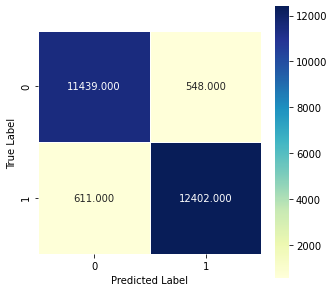

In [9]:
logreg = make_model(LogisticRegression(random_state=random_state), random_state)

Давайте поищем параметры по сетке:

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

logreg_pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', LogisticRegression(penalty='elasticnet', solver='saga', random_state=random_state))])
params = [{
    'regressor__l1_ratio': [0.1, 0.01, 0.001],
    'regressor__max_iter': [100, 200, 300, 400]
}]

best_logreg = GridSearchCV(logreg_pipeline, n_jobs=4, param_grid=params, scoring='f1', cv=5)
best_logreg.fit(X_train, y_train)

best_logreg.best_params_

{'regressor__l1_ratio': 0.1, 'regressor__max_iter': 100}

Сделаем такую модельку!

Train scores:
ROC-AUC score: 0.990577810157428
f1 score: 0.956774118648659


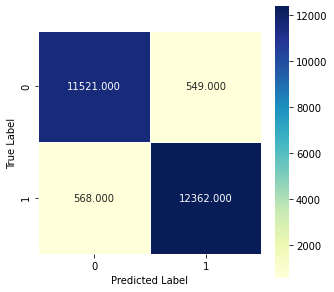

Testing scores:
ROC-AUC score: 0.9903079125955191
f1 score: 0.9553227545832692


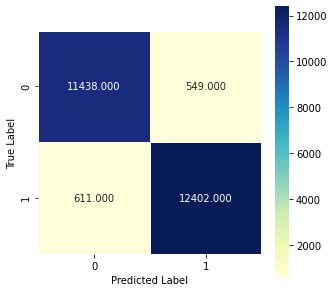

In [11]:
best_logreg = make_model(LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.1, max_iter=100, random_state=random_state), random_state)

### Деревья и леса

Train scores:
f1 score: 1.0


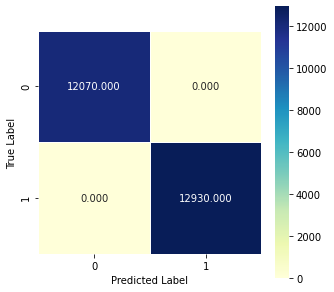

Testing scores:
f1 score: 0.9321009050645099


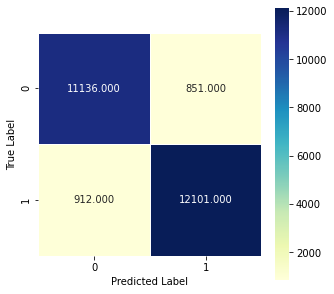

In [12]:
tree = make_model(DecisionTreeClassifier(random_state=random_state), random_state, is_proba=False)

Train scores:
f1 score: 1.0


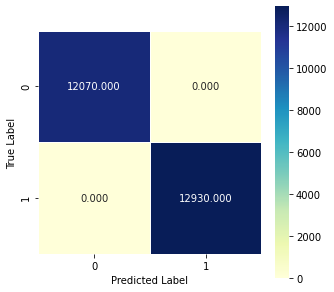

Testing scores:
f1 score: 0.9523184939433686


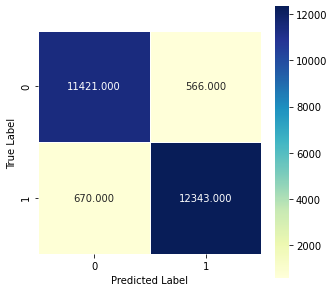

In [13]:
forest = make_model(RandomForestClassifier(random_state=random_state), random_state, is_proba=False)

Давайте устроим GridSearch по лесам (как минимум хочется обрезать им глубину, а то чёт переобучаются):

In [14]:
forest_pipeline = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestClassifier(random_state=random_state))])
params = [{
    'forest__n_estimators': [10, 50, 100, 150],
    'forest__max_depth': [None, 10, 5, 3]
}]

best_forest = GridSearchCV(forest_pipeline, n_jobs=4, param_grid=params, scoring='f1', cv=5)
best_forest.fit(X_train, y_train)

best_forest.best_params_

{'forest__max_depth': 10, 'forest__n_estimators': 100}

Train scores:
ROC-AUC score: 1.0
f1 score: 1.0


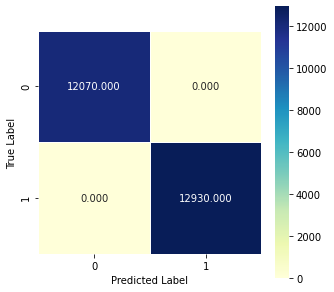

Testing scores:
ROC-AUC score: 0.9914650775872227
f1 score: 0.9520793914353013


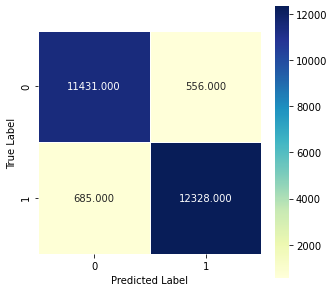

In [15]:
best_forest = make_model(RandomForestClassifier(max_depth=None, n_estimators=150, random_state=random_state), random_state)

That's all, folks!